# Setup

In [1]:
!pip install -q opendatasets

## Import libraries

In [62]:
import pandas as pd
import opendatasets as od
import numpy as np
import os
import tensorflow as tf
from PIL import Image
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten, Reshape, Input, BatchNormalization, Concatenate
from tensorflow.keras.models import Model

# Data Loading

In [3]:
od.download("https://www.kaggle.com/datasets/johnbergmann/captcha-image-dataset")

Dataset URL: https://www.kaggle.com/datasets/johnbergmann/captcha-image-dataset


100%|██████████| 39.5M/39.5M [00:04<00:00, 10.0MB/s]


In [4]:
DATA_URL = "/content/captcha-image-dataset/captchas"
train_dir = os.path.join(DATA_URL, "train")
test_dir = os.path.join(DATA_URL, "test")

# Data Preparation

In [69]:
BATCH_SIZE = 32
IMG_SIZE = (250,50)
N_LABELS = 36
D = 6 # number per image

In [28]:
files_train = []
labels_train = []

for filename in os.listdir(train_dir):
  files_train.append(os.path.join(train_dir, filename))
  labels_train.append(os.path.splitext(filename.split('_')[1])[0].lower())

files_val = []
labels_val = []

for filename in os.listdir(test_dir):
  files_val.append(os.path.join(test_dir, filename))
  labels_val.append(os.path.splitext(filename.split('_')[1])[0].lower())

In [29]:
df_train = pd.DataFrame({'file': files_train, 'label': labels_train})
df_val = pd.DataFrame({'file': files_val, 'label': labels_val})

In [30]:
df_train.head()

,file,label
0,/content/captcha-image-dataset/captchas/train/...,hz2gfv
1,/content/captcha-image-dataset/captchas/train/...,z2egx2
2,/content/captcha-image-dataset/captchas/train/...,uzmddg
3,/content/captcha-image-dataset/captchas/train/...,pgbdhv
4,/content/captcha-image-dataset/captchas/train/...,edbsmp


## Label Encoding

In [106]:
charset = "0123456789abcdefghijklmnopqrstuvwxyz"
chars_to_index = {char: i for i, char in enumerate(charset)}
index_to_chars = {i: char for i, char in enumerate(charset)}

In [107]:
def labels_to_indices(label):
  result = [chars_to_index[char] for char in label]
  return result

def indices_to_labels(indices):
  result = [index_to_chars[i] for i in indices]
  return ''.join(result)

In [33]:
label_1 = []
label_2 = []
label_3 = []
label_4 = []
label_5 = []
label_6 = []

for label in df_train['label']:
  l1, l2, l3, l4, l5, l6 = labels_to_indices(label)
  label_1.append(l1)
  label_2.append(l2)
  label_3.append(l3)
  label_4.append(l4)
  label_5.append(l5)
  label_6.append(l6)

df_train['label_1'] = label_1
df_train['label_2'] = label_2
df_train['label_3'] = label_3
df_train['label_4'] = label_4
df_train['label_5'] = label_5
df_train['label_6'] = label_6

In [34]:
label_1 = []
label_2 = []
label_3 = []
label_4 = []
label_5 = []
label_6 = []

for label in df_val['label']:
  l1, l2, l3, l4, l5, l6 = labels_to_indices(label)
  label_1.append(l1)
  label_2.append(l2)
  label_3.append(l3)
  label_4.append(l4)
  label_5.append(l5)
  label_6.append(l6)

df_val['label_1'] = label_1
df_val['label_2'] = label_2
df_val['label_3'] = label_3
df_val['label_4'] = label_4
df_val['label_5'] = label_5
df_val['label_6'] = label_6

In [35]:
df_train.drop(columns='label', inplace=True)
df_val.drop(columns='label', inplace=True)

In [36]:
df_train.head()

,file,label_1,label_2,label_3,label_4,label_5,label_6
0,/content/captcha-image-dataset/captchas/train/...,17,35,2,16,15,31
1,/content/captcha-image-dataset/captchas/train/...,35,2,14,16,33,2
2,/content/captcha-image-dataset/captchas/train/...,30,35,22,13,13,16
3,/content/captcha-image-dataset/captchas/train/...,25,16,11,13,17,31
4,/content/captcha-image-dataset/captchas/train/...,14,13,11,28,22,25


## Image processing

In [37]:
X_train = []
X_val = []

for filepath in df_train['file']:
  img = Image.open(filepath)
  img = np.array(img)
  X_train.append(img)

X_train = np.array(X_train)

for filepath in df_val['file']:
  img = Image.open(filepath)
  img = np.array(img)
  X_val.append(img)

X_val = np.array(X_val)

## Create tf dataset

In [78]:
from tensorflow.keras.utils import to_categorical

def one_hot_encode_labels(df):
  labels = []
  for i in range(1, 7):
    labels.append(to_categorical(df[f'label_{i}'], num_classes=N_LABELS))
  return np.array(labels).transpose((1,0,2))

train_labels = one_hot_encode_labels(df_train)
val_labels = one_hot_encode_labels(df_val)

train_dataset = tf.data.Dataset.from_tensor_slices((
  X_train, {f'output_{i+1}': train_labels[:, i] for i in range(6)}
)).shuffle(buffer_size=1000).batch(BATCH_SIZE)
val_dataset = tf.data.Dataset.from_tensor_slices((
  X_val, {f'output_{i+1}': val_labels[:, i] for i in range(6)}
)).shuffle(buffer_size=1000).batch(BATCH_SIZE)

In [82]:
for features, labels in train_dataset.take(1):
    print("Batch shape:", features.shape)
    print("First image shape:", features[0].shape)
    print("First labels:", labels)

Batch shape: (32, 50, 250, 3)
First image shape: (50, 250, 3)
First labels: {'output_1': <tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)>, 'output_2': <tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)>, 'output_3': <tf.Tensor: shape=(32, 36), dtype=float32, numpy=
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0.,

# Modelling

In [92]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D

base_model = VGG16(input_shape=(50, 250, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze the base model

input_layer = base_model.input
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = [Dense(36, activation="softmax", name=f'output_{i+1}')(x) for i in range(6)]

model = Model(inputs=input_layer, outputs=outputs)

58889256/58889256 [==============================] - 4s 0us/step


In [88]:
input_layer = Input(shape=(50, 250, 3))
x = Conv2D(64, (3, 3), activation="relu")(input_layer)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Conv2D(256, (3, 3), activation="relu")(x)
x = BatchNormalization()(x)
x = MaxPooling2D(2, 2)(x)
x = Dropout(0.25)(x)

x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = [Dense(36, activation="softmax", name=f'output_{i+1}')(x) for i in range(6)]

model = Model(inputs=input_layer, outputs=outputs)

In [93]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_10 (InputLayer)       [(None, 50, 250, 3)]         0         []                            
                                                                                                  
 block1_conv1 (Conv2D)       (None, 50, 250, 64)          1792      ['input_10[0][0]']            
                                                                                                  
 block1_conv2 (Conv2D)       (None, 50, 250, 64)          36928     ['block1_conv1[0][0]']        
                                                                                                  
 block1_pool (MaxPooling2D)  (None, 25, 125, 64)          0         ['block1_conv2[0][0]']        
                                                                                            

In [94]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

In [95]:
history = model.fit(
    train_dataset,
    epochs=10,
    validation_data=(val_dataset),
)

Epoch 1/10
266/266 [==============================] - 24s 67ms/step - loss: 22.4221 - output_1_loss: 3.7351 - output_2_loss: 3.7449 - output_3_loss: 3.7615 - output_4_loss: 3.7325 - output_5_loss: 3.7232 - output_6_loss: 3.7249 - output_1_accuracy: 0.0454 - output_2_accuracy: 0.0503 - output_3_accuracy: 0.0496 - output_4_accuracy: 0.0473 - output_5_accuracy: 0.0499 - output_6_accuracy: 0.0532 - val_loss: 18.4208 - val_output_1_loss: 3.0609 - val_output_2_loss: 3.0654 - val_output_3_loss: 3.0794 - val_output_4_loss: 3.0654 - val_output_5_loss: 3.0752 - val_output_6_loss: 3.0745 - val_output_1_accuracy: 0.0540 - val_output_2_accuracy: 0.0527 - val_output_3_accuracy: 0.0580 - val_output_4_accuracy: 0.0547 - val_output_5_accuracy: 0.0453 - val_output_6_accuracy: 0.0467
Epoch 2/10
266/266 [==============================] - 13s 49ms/step - loss: 18.7887 - output_1_loss: 3.1121 - output_2_loss: 3.1397 - output_3_loss: 3.1346 - output_4_loss: 3.1354 - output_5_loss: 3.1327 - output_6_loss: 3.1

In [114]:
from google.colab import files
uploaded = files.upload()

Saving 8514_bszavb.jpeg to 8514_bszavb (2).jpeg
Saving 8522_nprxdm.jpeg to 8522_nprxdm (1).jpeg
Saving 8549_cusan2.jpeg to 8549_cusan2 (1).jpeg


1/1 [==============================] - 0s 18ms/step


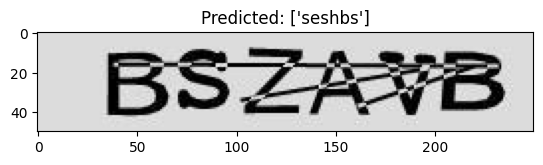

1/1 [==============================] - 0s 18ms/step


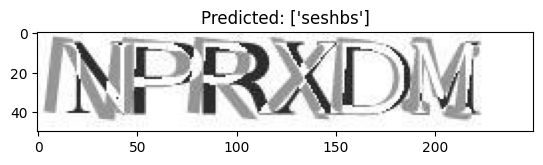

1/1 [==============================] - 0s 17ms/step


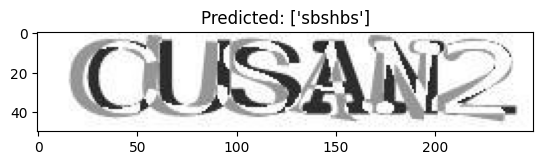

In [115]:
import matplotlib.pyplot as plt
for i, fn in enumerate(uploaded.keys()):
  img = Image.open(fn)
  img = img.resize((250, 50))  # Ensure the image size matches the input size of the model
  img_array = np.array(img) / 255.0
  img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension

  predictions = model.predict(img_batch)

  # Convert predictions to indices and then to characters
  predicted_labels = []

  for pred in zip(*predictions):
      pred_indices = [np.argmax(p) for p in pred]
      pred_labels = indices_to_labels(pred_indices)
      predicted_labels.append(pred_labels)

  plt.imshow(img)
  plt.title(f"Predicted: {predicted_labels}")
  plt.show()